In [435]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import warnings
from scipy import misc

In [253]:
# Display function for CIFAR-10
def display(image):
    plt.imshow(misc.toimage(image.reshape((3, 32, 32)).transpose(1,2,0)), interpolation = 'gaussian')
    plt.show()

In [3]:
data_directory_path = './Datasets/cifar-10-batches-py'

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
def loadBatch(filepath):
    """
    Loads the input data from the CIFAR-10 file given by filepath, encodes
    the labels given by scalars into hot key encoding vectors and returns
    the (X, Y, y) tuple where X is the inputs, Y the hotkey encodings and
    y and scalar labels.
    """
    dataset = unpickle(filepath)
    dataSamples = dataset[b'data']
    labels = dataset[b'labels']
    label_count = np.max(labels)
    hotKeyEncodings = np.array([[0 if labels[i] != j else 1 for j in range(label_count + 1)] for i in range(len(labels))])
    return dataSamples, hotKeyEncodings, labels

In [270]:
class Params:
    """
    Class containing hyperparameters used for
    gradient descent learning.
    
    Attributes:
        n_batch: Number of samples in each mini-batch.
        eta: Learning rate
        n_epochs: Maximum number of learning epochs.
    """
    def __init__(self, n_batch, eta, n_epochs):
        """ Constructor """
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs

In [444]:
class FeedforwardNet():
    """
    A single layer feedforward neural net implemention.
    
    Attributes:
        K: dimensons of output
        d: dimensions of input
        W: A Kxd matrix with the weights of the neural network.
        b: An 1xd vector with the bias values of each neuron.
    """
    
    
    def __init__(self, d, K, mean, s):
        """
        Initializes the Weight matrix and the bias vector
        with a Gaussian distribution.

        Args:
            d: input dimensions
            K: output dimensions
            mean: mean of Gaussian
            s: standard deviation of Gaussian

        Returns:
            A tuple with the weight matrix W and the bias vector b
            in this order.
        """
        self.K = K
        self.d = d
        self.W = np.random.normal(0, 0.01, (K, d)) # Weight matrix
        self.b = np.random.normal(0, 0.01, (K, 1)) # Bias vector
        
    def evaluateClassifier(self, X):
        """
        Evaluates the output of the classifier given the weights,
        the bias and the inputs.

        Args:
            X: An Nxd matrix with the N d-dimensional input samples.

        Returns:
            The  Kx1 output vector of the neural network passed through
            the softmax activation function.
        """
        s = np.dot(self.W, X.T) + self.b
        return self.softmax(s)

    def softmax(self, s):
        """
        Implementation of the softmax activation function

        Args:
            s: an 1xd vector of a classifier's outputs

        Returns:
            An 1xd vector with the results of softmax given the input
            vector s.
        """
        exponents = np.exp(s - np.max(s, axis = 0)) # Max subtraction for numerical stability
        output_exp_sum = np.sum(exponents, axis = 0)
        p = exponents / output_exp_sum
        p = np.where(p < 0.0, 0, p) #Round negative probabilities due to precision loss to zero
        return p


    def computeCost(self, X, Y, lamda):
        """
        Evaluates the loss function of the network.

        Args:
            X: Input matrix
            Y: Output matrix
            W: Weight matrix
            b: bias vector
            lambda: Constant that determines the amount
                of loss induced by the regularization term.
        Returns:
            A scalar corresponding to the loss.
        """
        return (1 / X.shape[0]) * np.sum(self.cross_entropy_loss(X, Y)) + lamda * np.sum(self.W ** 2)

    def cross_entropy_loss(self, X, Y):
        """
        Calculates the cross entropy loss
        """
        log_X = Y.dot(self.evaluateClassifier(X))
        log_X = np.where(log_X == 0, np.finfo(float).eps, log_X)
        return -np.log(log_X)
        

    def computeAccuracy(self, X, y):
        """
        Computes the accuracy of the network.

        Args:
            X: Input matrix
            y: Output labels
            
        Returns:
            The accuracy of the network (i.e. the percentage of
            correctly classified inputs in X).

        """
        softmax_outputs = self.evaluateClassifier(X) # Get probability distribution of outputs
        # Reduce to a vector of the labels with the highest probability
        predictions = np.argmax(softmax_outputs, axis = 0)
        accuracy = (predictions == y).mean()
        return accuracy    

    def computeGradients(self, X, Y, lamda, method = "analytical"):
        """
        Computes the gradient of the error with the regularization
        term with respect to the weights and the bias.

         Args:
            X: Input matrix
            Y: Desired output matrix
            lambda: Constant that determines the amount
                of loss induced by the regularization term.
            method: Type of method to be used to evaluate the gradients.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """
        
        P = self.evaluateClassifier(X)
        
        if method == "analytical":
            # Analytical computation of the gradient
            return self.computeAnalyticalGradients(X, Y, P, self.W, self.b, lamda)
        elif method == "fast_numerical":
            # Faster but less accurate calculation of the gradients
            return self.computeGradsNum(X, Y, P, self.W, self.b, lamda)
        elif method == "accurate_numerical":
            # More exact calculation of the gradients but slower
            return self.computeGradsNumSlow(X, Y, P, self.W, self.b, lamda)


    def computeGradsNum(self, X, Y, P, W, b, lamda, h = 1e-6):
        """
        Computes the gradient of the error function w.r.t the
        weights based on the finite difference method.

         Args:
            X: Input matrix
            Y: Desired output matrix
            P: Output matrix
            W: Weight matrix
            b: bias vector
            lambda: Constant that determines the amount
                of loss induced by the regularization term.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """ 
        N = X.shape[0]
        grad_W = np.zeros(W.shape)
        grad_b = np.zeros(b.shape)

        c = self.computeCost(X, Y, lamda);

        for i in range(b.shape[1]):
            self.b[i] += h;
            c2 = self.computeCost(X, Y, lamda);
            self.b[i] -= h;
            grad_b[i] = (c2-c) / h;

        W_try = np.copy(W)
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                self.W[i, j] += h
                c2 = self.computeCost(X, Y, lamda);
                self.W[i, j] -= h
                grad_W[i, j] = (c2-c) / h;

        return (grad_W, grad_b)

    def computeGradsNumSlow(self, X, Y, P, W, b, lamda, h = 1e-6):
        """
        Computes the gradient of the error function w.r.t the
        weights based on the centered difference formula.

         Args:
            X: Input matrix
            Y: Desired output matrix
            P: Output matrix
            W: Weight matrix
            b: bias vector
            lambda: Constant that determines the amount
                of loss induced by the regularization term.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """ 
        N = X.shape[0]
        grad_W = np.zeros(W.shape)
        grad_b = np.zeros(b.shape)

        c = self.computeCost(X, Y, lamda);

        for i in range(b.shape[1]):
            self.b[i] -= h;
            c1 = self.computeCost(X, Y, lamda);
            self.b[i] += 2 * h
            c2 = self.computeCost(X, Y, lamda);
            self.b[i] -= h
            grad_b[i] = (c2-c1) / (2 * h);

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                self.W[i,j] -= h
                c1 = self.computeCost(X, Y, lamda);
                self.W[i,j] += 2 * h
                c2 = self.computeCost(X, Y, lamda);
                self.W[i,j] -= h
                grad_W[i,j] = (c2-c1) / (2 * h);

        return (grad_W , grad_b)
    
    
    def computeAnalyticalGradients(self, X, Y, P, W, b, lamda):
        """
        Computes the gradient of the error function w.r.t the
        weights analytically.

        Args:
            X: Input matrix
            Y: Desired output matrix
            P: Output matrix
            W: Weight matrix
            b: bias vector
            lambda: Constant that determines the amount
                of loss induced by the regularization term.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """ 
        grad_W = np.zeros(W.shape)
        grad_b = np.zeros(b.shape)
        N = X.shape[0]

        for i in range(N):
            x = X[i].reshape(1,-1)
            y = Y[i].reshape(-1,1)
            p = self.evaluateClassifier(x)
                                 
            #t1 = np.outer(p, p)
            #t2 = np.diag(p) - t1
            #t3 = np.dot(y, t2 )
            #t4 = np.dot(y, p)
            #if t4 == 0:
                #t4 = np.finfo(float).eps
            #g = - t3 / t4
            #grad_W += np.outer(g, x)
            #grad_b += np.reshape(g, grad_b.shape)
            #Simpler formula - not functional           
            g = -(y - p)
            grad_b += g
            grad_W += g.dot(x)
        grad_W /= N
        grad_b /= N
        grad_W += 2 * lamda * W
        return (grad_W, grad_b)
    
    def miniBatchGD(self, X, Y, GDparams, lamda, GDmethod = "analytical"):
        """
        Implementation of mini-batch gradient descent.

         Args:
            X: Input matrix
            Y: Desired output matrix
            GDparams: Object of the class Params with the hyperparameters
                used for learning.
            W: Initial weight matrix
            b: Initial bias vector
            lamda: Constant that determines the amount
                of loss induced by the regularization term.
            GDmethod: Method used to approximate gradient descent.

        Returns:
            A tuple with the new weight matrix learned W as well as the 
            bias vector b in that order (i.e. (W, b)).
        """
        mini_batch_count = X.shape[0] // GDparams.n_batch
        for i in range(GDparams.n_epochs):
            for j in range(mini_batch_count):
                if(j < mini_batch_count - 1):
                    start = j * GDparams.n_batch
                    end = start + GDparams.n_batch
                    mini_batch_input = X[start:end]
                    mini_batch_output = Y[start:end]
                else:
                    # Take the remaining samples in the last mini batch
                    mini_batch_input = X[j * GDparams.n_batch:]
                    mini_batch_output = Y[j * GDparams.n_batch:]
                grad_W, grad_b = self.computeGradients(mini_batch_input, mini_batch_output,
                                                    lamda, method = GDmethod)
                self.W -= GDparams.eta * grad_W
                self.b -= GDparams.eta * grad_b
        

In [387]:
def getRelativeErrors(grad1, grad2):
    """
    Computes the relative errors of grad_1 and grad_2 gradients
    """
    abs_diff = np.absolute(grad_W2 - grad_W1) 
    max_elems = np.where(np.absolute(grad_W2)
                            - np.absolute(grad_W1) > 0.0, np.absolute(grad_W2), np.absolute(grad_W1))
    cond = max_elems != np.zeros(max_elems.shape)
    relativeErrors = np.zeros(max_elems.shape)
    relativeErrors[cond] = abs_diff[cond] / max_elems[cond]
    return relativeErrors

In [373]:
# Load training data (X is the input data, Y the hotkey encodings and y the label code numbers)
#X_tr, Y_tr, y_tr = loadBatch(data_directory_path + '/data_batch_' + str(1))
BatchList = []
for i in range(1,6):
    Xnew, Ynew, ynew = loadBatch(data_directory_path + '/data_batch_' + str(i))
    #X_tr = np.vstack((X_tr, Xnew))
    #Y_tr = np.vstack((Y_tr, Ynew))
    #y_tr = np.hstack((y_tr, ynew))
    BatchList.append((Xnew, Ynew, ynew))

In [374]:
# Holdout data from training data for the validation set
X_tr, Y_tr, y_tr  = BatchList[0]
X_val, Y_val, y_val = BatchList[1]

In [375]:
# Load test data
X_tst, Y_tst, y_tst = loadBatch(data_directory_path + '/test_batch')

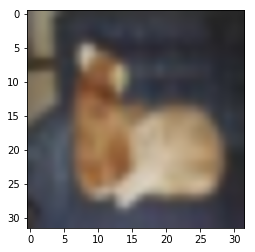

In [376]:
# Visualize an image for debugging reasons
image_index = 17
display(X_tr[image_index])

### Running the network's functions without training

In [442]:
## Initialize model parameters
N = X_tr.shape[0] # Number of samples
d = X_tr.shape[1] # Input dimensionality
K = Y_tr.shape[1] # Output dimensionality
mean = 0.0
standard_deviation = 0.01
network_model = FeedforwardNet(d, K, mean, standard_deviation)
# Checking that the function works on a subset of inputs
P = network_model.evaluateClassifier(X_tr[:100])
sums = np.sum(P, axis = 0)
print("SUMS OF PROBABILITIES IN THE OUTPUTS: " + str(sums)) # Check if the sums for each sample sum up to 1
cost = network_model.computeCost(X_tr, Y_tr, lamda = 1)
print("LOSS FUNCTION VALUE: " + str(cost))
acc = network_model.computeAccuracy(X_tr, y_tr)
print("ACCURACY: " + str(acc))

SUMS OF PROBABILITIES IN THE OUTPUTS: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
LOSS FUNCTION VALUE: 775396.980681
ACCURACY: 0.1116


### Debugging gradients

#### Mini-batch of 100, No regularization imposed

In [424]:
N = X_tr.shape[0] # Number of samples
d = X_tr.shape[1] # Input dimensionality
K = Y_tr.shape[1] # Output dimensionality
mean = 0.0
standard_deviation = 0.01
samples = 100
GD_checking_net = FeedforwardNet(d, K, mean, standard_deviation)
lamda = 0.0
grad_W1, grad_b1 = GD_checking_net.computeGradients(X_tr2[:samples], Y_tr[:samples], lamda, method = "analytical")
grad_W2, grad_b2 = GD_checking_net.computeGradients(X_tr2[:samples], Y_tr[:samples], lamda, method = "fast_numerical")
grad_W3, grad_b3 = GD_checking_net.computeGradients(X_tr2[:samples], Y_tr[:samples], lamda, method = "accurate_numerical")
# Compare fast numerical method with analytical estimation of gradient
relativeErrorsFast = np.abs(grad_W1 - grad_W2)
print("FINITE DIFFERENCE FORMULA COMPARISON")
print("MAX RELATIVE ERROR: " + str(np.max(relativeErrorsFast)))
print("MIN RELATIVE ERROR: " + str(np.min(relativeErrorsFast)))
print("MEAN RELATIVE ERROR: " + str(np.mean(relativeErrorsFast)))
# Compare accurate numerical method with analytical estimation of gradient
relativeErrorsSlow = np.abs(grad_W1 - grad_W3)
print("CENTERED DIFFERENCE FORMULA COMPARISON")
print("MAX RELATIVE ERROR: " + str(np.max(relativeErrorsSlow)))
print("MIN RELATIVE ERROR: " + str(np.min(relativeErrorsSlow)))
print("MEAN RELATIVE ERROR: " + str(np.mean(relativeErrorsSlow)))
relativeErrorsNum = np.abs(grad_W2 - grad_W3)
print("ERRORS BETWEEN NUMERICAL APPROXIMATIONS")
print("MAX RELATIVE ERROR: " + str(np.max(relativeErrorsNum)))
print("MIN RELATIVE ERROR: " + str(np.min(relativeErrorsNum)))
print("MEAN RELATIVE ERROR: " + str(np.mean(relativeErrorsNum)))

FINITE DIFFERENCE FORMULA COMPARISON
MAX RELATIVE ERROR: 6240.81959694
MIN RELATIVE ERROR: 207.412864358
MEAN RELATIVE ERROR: 1528.57483417
CENTERED DIFFERENCE FORMULA COMPARISON
MAX RELATIVE ERROR: 6240.80790993
MIN RELATIVE ERROR: 207.41825948
MEAN RELATIVE ERROR: 1528.57331698
ERRORS BETWEEN NUMERICAL APPROXIMATIONS
MAX RELATIVE ERROR: 0.0189002093975
MIN RELATIVE ERROR: 0.0
MEAN RELATIVE ERROR: 0.00185818462839


### Task 7. Perform mini-batch gradient descent

In [ ]:
network_model = FeedforwardNet(d, K, mean, standard_deviation)
GDparams = Params(n_batch = 100, eta = 0.01, n_epochs = 20) # Object with hyperaparams
lamda = 1.0 # Regularization constant
network_model.miniBatchGD(X_tr, Y_tr, GDparams, lamda, GDmethod = "accurate_numerical")

In [ ]:
# Visualize learned weights as pictures
print(W.shape)
for i in range(len(W)):
    display(W[i])

In [ ]:
acc = network_model.computeAccuracy(X_tr, y_tr)
print(acc)